# Monte Carlo based algo

## Libraries


In [16]:
import gym
from tqdm import tqdm
import numpy as np
import time
import metrics_m as mm

## Useful side function(s)
### max_dict(dictonary)
This function aim is to return a tuple of values (key,values) where value is the maximum all the whole dictionary

In [17]:
# -- Gey key,value where value is the maximum in the given dictionary --
def max_dict(d):
    max_key = None
    max_val = float('-inf')

    for k, v in d.items():
        if v > max_val:
            max_key = k
            max_val = v
    
    return max_key, max_val

## Core algorithm
Monte Carlo method is a very simple concept where agent learn about the states and reward when it interacts with the environment. In this method agent generate experienced samples and then based on average return, value is calculated for a state or state-action.

This algorithm as it's a probabilistic one, uses more ways to store experience data than other reinforcement learning algorithms.



### Function to initialize data structures
Here we'll use 3 different ones :
* Q : to store the pair (state,action) => score
* policy : to store the better of Q's according to the score value, because this is the most relevant way to take an action. Policy, basically is the structure used used by the agent to take decision
Thus, the shape of policy is (state) => action
* returns : this structure has the same shape as Q for the simple reason that it's used like a temporary storage to compute Q's

At first and because Monte Carlo is a probabilistic theorem, we initialize policy by associating each state with a random action among the ones possible.
Q's and return are initialize with every pair (state,action) known and empty score.

In [18]:
# -- CREATE A RANDOM POLICY --
def initPolicy():
    policy = {}
    for state in range(env.observation_space.n):
        policy[state] = env.action_space.sample()
    return policy

# -- INITIALIZATION OF Q(state,action) an Returns --
def initQ():
    Q = {}
    returns = {}
    for state in range(env.observation_space.n):
        Q[state] = {}
        for action in range(env.action_space.n):
            Q[state][action] = 0
            returns[(state,action)] = []

    return Q, returns

### Play one game function
This algorithm is quit strict. The way it works for each game is the following :
* First step is a random action
* Next steps are taked from policy (which at first is also filled with random actions)
* The game stops if :
    * It is finished : GG
    * The agent crash into a wall
* For each game we save :
    * state_action_reward : as it's name says, it store a list of tuple [(state_game_1, action_game_1, reward_game_1), ... , (state_game_n, action_game_n, reward_game_n))] for each simulation (games)
    * state_action_returns : which basically is the same as state_action_reward but instead of having reward in it, we have return which is like a commputed score to tell how well this action performs at this state
    

In [19]:
def one_game(policy):
    env.reset()
    state_action_reward = []
    done = None
    steps_counter = 0
    # History (no duplicates) of seen state to avoid being stuck in a wall
    seen_states = set()

    # - Play the game - (Do steps until stuck in a wall or game done)
    while True:
        # Get the current state we are at
        current_state = env.s

        # Logging
        # print(f"Begin state { current_state }")

        # ACTION CHOICE
        # First step is random
        if steps_counter == 0:
            action = env.action_space.sample()

        # Other steps are 
        else:
            # Pick up the action to take according the policy
            action = policy[current_state] 

        # Logging
        # print(f"Action { action }")

        # Take the step
        next_state, reward, done, info = env.step(action) 

        # Increase step counter
        steps_counter += 1

        # Reward attribution and state/action/reward storing
        # If the agent hasn't move
        if current_state in seen_states:

            # Redefine a reward
            # reward =  round(-10 / steps_counter, 2)

            # Feed state action reward data structure
            state_action_reward.append((current_state,None,reward)) 

            # Logging
            # print("Agent stuck -> get go next game")
            break

        # If the game is completed, add the 
        elif done:
            state_action_reward.append((current_state,None,reward)) 
            # print("Game finished successfully -> get go next game")
            break
       
        else:
            state_action_reward.append((current_state,action,reward)) 
            # print("Store value of the step and go next step")
        
        seen_states.add(current_state)


    # Logging
    # pprint.pprint(state_action_reward)


    # - SCORE / RETURNS CALCULUS -
    score = 0
    state_action_returns = []
    isFirstIteration = True

    # Go through eact action taken and calculate a score
    for state, action, reward in reversed(state_action_reward):
        
        # Don't add the last action to the returns because it's anyway a None (in case of Fail Or Win)
        isFirstIteration = False if isFirstIteration else state_action_returns.append((state,action,score))
        
        #Score formula (even if it's the last action, we need to update te score considering the reward it gets)
        score = reward + GAMMA * score

        # Logging
        # print(f"State : { state } / Action : { action } / Reward : { reward } / Score :  { score }")
    
    rewards = [i[2] for i in state_action_reward]

    # Return the returns
    return list(reversed(state_action_returns)) , steps_counter, done, rewards


### Train function
The train is about taking those state_action_returns and process them to update policy, Q's and returns to be able to have a policy that performs well.
By looping throught state_action_returns of each steps of the games we update
* returns(state,action) = [...+return] :  add the score to the ones previously computed for the same state, action pair
* Q(state,action) = mean of this state action of all returns stored in returns
* policy = by attributing the action that has the maximum score in Q to the paired state

In [20]:

# -- FIT FUNCTION -- 
def fit(policy, Q, returns, nb_games):
    # policy = save_policy
    deltas = []
    all_games_steps_counts = [0]
    all_games_times = []
    all_games_rewards = []
    all_games_win_lose = []
    max_reward = float("-inf")
    min_reward = float("+inf")

    for i in tqdm(range(nb_games)):
        t0 = time.time()
        # print(f"Game { i }")
        biggest_change = 0
        state_action_returns, steps, done, rewards =  one_game(policy)    
        seen_state_action =  set()
        all_games_steps_counts.append(steps)
        all_games_rewards.append(np.mean([i[2] for i in state_action_returns]))
        cumulative_rewards = cumulative_rewards = sum(rewards)

        if cumulative_rewards > max_reward:
            max_reward = cumulative_rewards
        if cumulative_rewards < min_reward:
            min_reward = cumulative_rewards

        if done :
            all_games_win_lose.append(1)
        else :
            all_games_win_lose.append(0)
     
        for state, action, score in state_action_returns:
            rewards.append(score)
            sa = (state,action)
            if sa not in seen_state_action:
                old_q =  Q[state][action]
                returns[sa].append(score)
                Q[state][action] = np.mean(returns[sa])
                biggest_change = max(biggest_change, np.abs(old_q -  Q[state][action] ))
                seen_state_action.add(sa)
            deltas.append(biggest_change)
        
        # Update policy
        for state in policy.keys():
            # if max_dict(Q[state])[0] is None:  
            policy[state] = max_dict(Q[state])[0]
        
        game_time = time.time()-t0
        all_games_times.append(game_time)

    return_dict = {}
    return_dict["games_steps_counts"] = all_games_steps_counts
    return_dict["deltas"] = deltas
    return_dict["biggest_change"] = biggest_change
    return_dict["policy"] = policy
    return_dict["games_times"] = all_games_times
    return_dict["rewards"] = all_games_rewards
    return_dict["win_lose"] = all_games_win_lose
    return_dict["max_reward"] = max_reward,
    return_dict["min_reward"] = min_reward
    
    return return_dict


## Optimization
Because this algorithms is mainly based on randomness and only have 1 hyperparameter, optimization isn't really revelant on this one. Moreover the fact that this algorithm won't work properly here makes even more irrelevant the optimization step.

## Training

In [21]:
# Set up env and hyperparameter
env = gym.make("Taxi-v3").env
GAMMA = 0.9
nb_games = 100000

# Initialize every variable to store simulation infos
Q , returns = initQ()
policy = initPolicy()

# Train
results = fit(policy, Q,returns, nb_games)

100%|██████████| 100000/100000 [01:05<00:00, 1524.84it/s]


## Metrics

### Steps

#### Graph

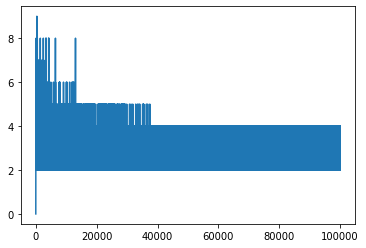

{'q1': 2.0, 'median': 2.0, 'q3': 3.0, 'max': 9, 'min': 0}

In [22]:
mm.statMetrics(results["games_steps_counts"], plot=True)

#### Better and worst

In [23]:
mm.minmaxMetrics(results["games_steps_counts"])

{'min': 0, 'min_game': 0, 'max': 9, 'max_game': 351}

### Rewards

#### Graph

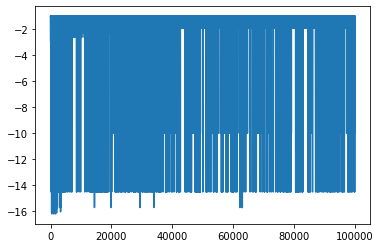

{'q1': -1.45, 'median': -1.0, 'q3': -1.0, 'max': -1.0, 'min': -16.1902}

In [24]:
mm.statMetrics(results["rewards"], plot=True)

### Better and worst

In [25]:
mm.minmaxMetrics(results["rewards"])

{'min': -16.1902, 'min_game': 448, 'max': -1.0, 'max_game': 0}

In [26]:
print(f"Overall games min reward : { results['min_reward'] } ")
print(f"Overall games max reward : { results['max_reward'] }")

Overall games min reward : -26 
Overall games max reward : (-2,)


### Runtime

#### Graph

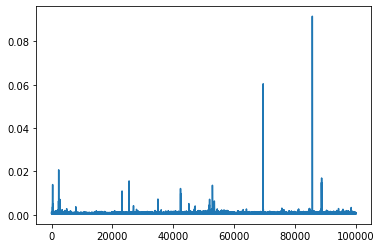

{'q1': 0.0005178451538085938,
 'median': 0.0005750656127929688,
 'q3': 0.0006990432739257812,
 'max': 0.09155726432800293,
 'min': 0.00040984153747558594}

In [27]:
mm.statMetrics(results["games_times"], plot=True)

#### Better and worst

In [28]:
mm.minmaxMetrics(results["games_times"])

{'min': 0.00040984153747558594,
 'min_game': 4,
 'max': 0.09155726432800293,
 'max_game': 85679}

### Win/Lose Rates

In [29]:
mm.rateMetrics(results["win_lose"])

{'winrate': 0.0, 'lossrate': 1.0, 'winrate_%': 0, 'lossrate_%': 100}

## Test

In [30]:
# -- TEST -- runs forever
env = gym.make("Taxi-v3").env
env.reset()
done = None
while not done:
    current_state = env.s
    next_state, reward, done, info = env.step(policy[current_state]) 

KeyboardInterrupt: 